In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 6272, done.
remote: Counting objects: 100% (1461/1461), done.
remote: Compressing objects: 100% (303/303), done.
remote: Total 6272 (delta 1255), reused 1336 (delta 1149), pack-reused 4811
Receiving objects: 100% (6272/6272), 2.94 GiB | 19.02 MiB/s, done.
Resolving deltas: 100% (5081/5081), done.
Updating files: 100% (505/505), done.


In [2]:
! pip install implicit

  Obtaining dependency information for implicit from https://files.pythonhosted.org/packages/cd/cc/deac70cae8cc32c9885d0cd73bc66e1b3cbea36ae7080b8c83995eaf5322/implicit-0.7.2-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 46.8 MB/s eta 0:00:00


In [3]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 22.1 MB/s eta 0:00:00


In [4]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorization_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorization_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorization_Cython_Epoch.c: In function ‘__pyx_pf_32MatrixFactorization

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps
from concurrent.futures import ThreadPoolExecutor

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv
/kaggle/input/training-tuned-models/als_all.npz
/kaggle/input/training-tuned-models/__results__.html
/kaggle/input/training-tuned-models/ease_r_all.zip
/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip
/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz
/kaggle/input/training-tuned-models/als_train_validation.npz
/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/slim_recall_train_validation.zip
/kaggle/input/training-tuned-models/ease_r_train_validation.zip
/kaggle/input/training-tuned-models/__notebook__.ipynb
/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/ials_train_validation.zip
/kaggle/input/training-tuned-models/mult_vae_2_all.zip
/kaggle/input/training-tuned-models/ease_r_xgbo

In [6]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [7]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender, SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender, PureSVDItemRecommender, ScaledPureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.NonPersonalizedRecommender import TopPop

from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Data_manager.CrossValidationSplitter import CrossValidationSplitter
from Recommenders.MatrixFactorization.ALSImplicitRecommender import ALSImplicitRecommender
from Recommenders.GraphBased.HHPRecommender import HHPRecommender
from Recommenders.GraphBased.TwoWayRankAggregationRecommender import TwoWayRankAggregationRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [8]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [9]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [10]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [11]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [12]:
URM_train, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_validation, URM_test = split_train_in_two_percentage_global_sample(URM_test_complete, train_percentage = 0.8)

In [13]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_item.json', 'r') as params_file:
    params_item_knn = json.load(params_file)
params_item_knn

{'topK': 14,
 'shrink': 25,
 'similarity': 'tversky',
 'tversky_alpha': 0.18163095712123836,
 'tversky_beta': 1.8529812241698465}

In [14]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_RP3.json', 'r') as params_file:
    params_rp3 = json.load(params_file)
params_rp3

{'alpha': 0.3408516511081212, 'beta': 0.1447198697205665, 'topK': 32}

In [15]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_user.json', 'r') as params_file:
    params_user_knn = json.load(params_file)
params_user_knn

{'topK': 498,
 'shrink': 0,
 'similarity': 'asymmetric',
 'asymmetric_alpha': 0.39792525383867455}

In [16]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_alpha.json', 'r') as params_file:
    params_p3alpha = json.load(params_file)
params_p3alpha

{'normalize_similarity': 'True',
 'implicit': 'True',
 'alpha': 0.29354071531607107,
 'topK': 49}

In [17]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_merging.json', 'r') as params_file:
    params_merging = json.load(params_file)
params_merging

{'alpha': 0.3375591188839621, 'topK': 86}

In [18]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/pure_svd_params.json', 'r') as params_file:
    params_pure_svd = json.load(params_file)
params_pure_svd

{'factors': 30}

In [19]:
# with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_item.json', 'r') as params_file:
#     params_pure_svd_item = json.load(params_file)
params_pure_svd_item = {"topK": 43, "num_factors": 171}

In [20]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_scaled.json', 'r') as params_file:
    params_scaled = json.load(params_file)
params_scaled

{'num_factors': 179,
 'scaling_items': 5.3298425368534826e-05,
 'scaling_users': 0.2791990262721904}

In [21]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hhp.json', 'r') as params_file:
    params_hhp = json.load(params_file)
params_hhp

{'hybrid_lambda': 0.8450256587797654, 'topK': 61}

In [22]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_twra.json', 'r') as params_file:
    params = json.load(params_file)

params_twra = {
    'base_f_algorithm': params['base_f_algorithm'], 
    'base_b_algorithm': params['base_b_algorithm'], 
    'convex_lambda': params['convex_lambda'],
}

if params['base_f_algorithm'] == 'p3':
    params_twra['f_params'] = {
        'topK': params['f_p3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_f_algorithm'] == 'p3alpha':
    params_twra['f_params'] = {
        'alpha': params['f_p3a_alpha'],
        'topK': params['f_p3a_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_f_algorithm'] == 'rp3beta':
    params_twra['f_params'] = {
        'alpha': params['f_rp3_alpha'],
        'beta': params['f_rp3_beta'],
        'topK': params['f_rp3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
else:
    params_twra['f_params'] = {
        'hybrid_lambda': params['f_hhp_hybrid_lambda'],
        'topK': params['f_hhp_topK'],
    }

if params['base_b_algorithm'] == 'p3':
    params_twra['b_params'] = {
        'topK': params['b_p3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_b_algorithm'] == 'p3alpha':
    params_twra['b_params'] = {
        'alpha': params['b_p3a_alpha'],
        'topK': params['b_p3a_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_b_algorithm'] == 'rp3beta':
    params_twra['b_params'] = {
        'alpha': params['b_rp3_alpha'],
        'beta': params['b_rp3_beta'],
        'topK': params['b_rp3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
else:
    params_twra['b_params'] = {
        'hybrid_lambda': params['b_hhp_hybrid_lambda'],
        'topK': params['b_hhp_topK'],
    }

In [23]:
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip', 
    '/kaggle/working/ials_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_train_validation.zip', 
    '/kaggle/working/ials_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_all.zip', 
    '/kaggle/working/ials_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz', 
    '/kaggle/working/als_xgboost_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_train_validation.npz', 
    '/kaggle/working/als_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_all.npz', 
    '/kaggle/working/als_all.npz', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip', 
    '/kaggle/working/mult_vae_2_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip', 
    '/kaggle/working/mult_vae_2_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_all.zip', 
    '/kaggle/working/mult_vae_2_all.zip', 
)

'/kaggle/working/mult_vae_2_all.zip'

In [24]:
recommender_top_pop = TopPop(URM_train)
recommender_top_pop.fit()

recommender_item = ItemKNNCFRecommender(URM_train)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_train_validation')

recommender_hhp = HHPRecommender(URM_train)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train)
recommender_twra.fit(**params_twra)

recommender_als = ALSImplicitRecommender(URM_train)
recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

TopPopRecommender: URM Detected 627 ( 4.8%) users with no interactions.
TopPopRecommender: URM Detected 247 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 22347 (100.0%), 3228.84 column/sec. Elapsed time 6.92 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 3422.03 column/sec. Elapsed time 3.81 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2776.68 column/sec. Elapsed time 8.05 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommend

/opt/conda/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


In [25]:
evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])

print('Item KNN')
result_df, _ = evaluator.evaluateRecommender(recommender_item)
display(result_df)
print('RP3 beta')
result_df, _ = evaluator.evaluateRecommender(recommender_rp3)
display(result_df)
print('P3 alpha')
result_df, _ = evaluator.evaluateRecommender(recommender_p3a)
display(result_df)
print('User KNN')
result_df, _ = evaluator.evaluateRecommender(recommender_user)
display(result_df)
print('NMF')
result_df, _ = evaluator.evaluateRecommender(recommender_nmf)
display(result_df)
print('Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_pure_svd)
display(result_df)
print('Scaled Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_scaled_svd)
display(result_df)
print('Item Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_pure_svd_item)
display(result_df)
print('SLIM BPR')
result_df, _ = evaluator.evaluateRecommender(recommender_slim_bpr)
display(result_df)
print('SLIM Elastic')
result_df, _ = evaluator.evaluateRecommender(recommender_slim)
display(result_df)
print('EASE R')
result_df, _ = evaluator.evaluateRecommender(recommender_ease_r)
display(result_df)
print('IALS')
result_df, _ = evaluator.evaluateRecommender(recommender_ials)
display(result_df)
print('MultVAE')
result_df, _ = evaluator.evaluateRecommender(recommender_vae)
display(result_df)
print('HHP')
result_df, _ = evaluator.evaluateRecommender(recommender_hhp)
display(result_df)
print('TWRA')
result_df, _ = evaluator.evaluateRecommender(recommender_twra)
display(result_df)
print('ALS')
result_df, _ = evaluator.evaluateRecommender(recommender_als)
display(result_df)
print('Top Pop')
result_df, _ = evaluator.evaluateRecommender(recommender_top_pop)
display(result_df)

EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
Item KNN
EvaluatorHoldout: Processed 10456 (100.0%) in 8.82 sec. Users per second: 1185


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.09451,0.161146,0.135378,0.048719,0.082976,0.267977,0.148683,0.111312,0.511572,0.356662,...,0.802826,0.410703,0.802826,0.066309,10.283111,0.997789,0.191329,0.792171,1.734564,0.30426


RP3 beta
EvaluatorHoldout: Processed 10456 (100.0%) in 8.83 sec. Users per second: 1185


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.095008,0.162969,0.137154,0.04916,0.084325,0.273626,0.150836,0.112255,0.517598,0.361989,...,0.802826,0.415541,0.802826,0.095265,10.876609,0.998685,0.274877,0.837892,1.348527,0.315394


P3 alpha
EvaluatorHoldout: Processed 10456 (100.0%) in 8.71 sec. Users per second: 1200


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.092358,0.15618,0.130929,0.047745,0.081353,0.267656,0.146022,0.108312,0.507269,0.352674,...,0.802826,0.407248,0.802826,0.069984,10.530815,0.998437,0.201933,0.811253,1.356167,0.311674


User KNN
EvaluatorHoldout: Processed 10456 (100.0%) in 12.86 sec. Users per second: 813


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.07172,0.128756,0.110157,0.035281,0.062836,0.223137,0.116955,0.086877,0.446251,0.278756,...,0.802826,0.358262,0.802826,0.012513,7.842357,0.986392,0.036106,0.604145,3.565726,0.26052


NMF
EvaluatorHoldout: Processed 10456 (100.0%) in 10.93 sec. Users per second: 957


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.063045,0.105178,0.087319,0.032528,0.054161,0.204864,0.101315,0.073223,0.389441,0.256311,...,0.802826,0.312654,0.802826,0.019455,9.192063,0.997904,0.056136,0.708121,1.345964,0.290279


Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 10.72 sec. Users per second: 975


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.058655,0.100586,0.084556,0.029356,0.049861,0.191304,0.094675,0.069264,0.379112,0.235505,...,0.802826,0.304361,0.802826,0.006201,7.529534,0.992933,0.017892,0.580046,2.618313,0.263304


Scaled Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 12.98 sec. Users per second: 805


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.064097,0.109815,0.092927,0.032531,0.055816,0.210252,0.104525,0.075865,0.406561,0.259989,...,0.802826,0.326397,0.802826,0.014436,8.746799,0.996979,0.041653,0.673819,1.928255,0.276719


Item Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 14.44 sec. Users per second: 724


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.065541,0.110029,0.091588,0.033231,0.054743,0.208886,0.103893,0.076406,0.405222,0.261456,...,0.802826,0.325322,0.802826,0.018829,9.102948,0.997654,0.05433,0.701256,1.415577,0.290871


SLIM BPR
EvaluatorHoldout: Processed 10456 (100.0%) in 10.40 sec. Users per second: 1005


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.06644,0.117629,0.100236,0.032851,0.058715,0.211463,0.10894,0.079912,0.421576,0.261863,...,0.802826,0.338452,0.802826,0.026478,8.936844,0.995212,0.0764,0.68846,2.525497,0.277014


SLIM Elastic
EvaluatorHoldout: Processed 10456 (100.0%) in 12.47 sec. Users per second: 839


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.097752,0.165757,0.139187,0.05124,0.086426,0.282607,0.154679,0.114847,0.52477,0.375707,...,0.802826,0.421299,0.802826,0.059374,10.474793,0.998673,0.171318,0.806937,1.547674,0.300111


EASE R
EvaluatorHoldout: Processed 10456 (100.0%) in 14.06 sec. Users per second: 743


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.092081,0.159369,0.134879,0.047426,0.081665,0.270652,0.147329,0.109445,0.512911,0.354475,...,0.802826,0.411778,0.802826,0.040505,9.941662,0.998079,0.116873,0.765867,1.784638,0.291167


IALS
EvaluatorHoldout: Processed 10456 (100.0%) in 14.21 sec. Users per second: 736


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.08224,0.144123,0.122645,0.041501,0.071584,0.246255,0.131701,0.098458,0.479055,0.316769,...,0.802826,0.384598,0.802826,0.029074,9.74689,0.998532,0.08389,0.750862,1.599865,0.289534


MultVAE
EvaluatorHoldout: Processed 10456 (100.0%) in 19.23 sec. Users per second: 544


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.075507,0.13913,0.120293,0.036057,0.065255,0.226509,0.12231,0.092778,0.468057,0.28421,...,0.802826,0.375768,0.802826,0.019135,8.047588,0.98282,0.055213,0.619955,3.723978,0.258919


HHP
EvaluatorHoldout: Processed 10456 (100.0%) in 9.24 sec. Users per second: 1132


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.082259,0.141172,0.118574,0.04201,0.072025,0.242682,0.130784,0.097133,0.468057,0.315505,...,0.802826,0.375768,0.802826,0.11163,11.131278,0.99879,0.322096,0.85751,1.316872,0.32161


TWRA
EvaluatorHoldout: Processed 10456 (100.0%) in 1.47 min. Users per second: 118


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.09561,0.163025,0.136845,0.049692,0.084977,0.277154,0.151798,0.11257,0.519415,0.366092,...,0.802826,0.416999,0.802826,0.09979,10.867444,0.998608,0.287935,0.837186,1.4775,0.310692


ALS
EvaluatorHoldout: Processed 10456 (100.0%) in 13.76 sec. Users per second: 760


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.087108,0.156441,0.13419,0.043625,0.076944,0.255751,0.140496,0.10564,0.5,0.330871,...,0.802826,0.401413,0.802826,0.040084,10.054864,0.998359,0.115658,0.774588,1.762738,0.289017


Top Pop
EvaluatorHoldout: Processed 10456 (100.0%) in 9.09 sec. Users per second: 1150


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.029122,0.055004,0.04735,0.011658,0.021405,0.091258,0.045389,0.036064,0.232211,0.102788,...,0.802826,0.186425,0.802826,0.000545,3.662824,0.915933,0.001572,0.28217,6.141453,0.224558


In [26]:
profile_length = np.ediff1d(sps.csr_matrix(URM_train).indptr)
block_size = int(len(profile_length)*0.05)
profile_length, profile_length.shape, block_size

(array([34, 34,  3, ...,  5, 21, 60], dtype=int32), (13024,), 651)

In [27]:
sorted_users = np.argsort(profile_length)
sorted_users

array([12616, 11595,  7945, ...,  5658,  9911, 12095])

In [28]:
for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

Group 0, #users in group 651, average p.len 0.04, median 0.0, min 0, max 1
Group 1, #users in group 651, average p.len 1.00, median 1.0, min 1, max 1
Group 2, #users in group 651, average p.len 1.50, median 2.0, min 1, max 2
Group 3, #users in group 651, average p.len 2.38, median 2.0, min 2, max 3
Group 4, #users in group 651, average p.len 3.45, median 3.0, min 3, max 4
Group 5, #users in group 651, average p.len 4.69, median 5.0, min 4, max 5
Group 6, #users in group 651, average p.len 6.29, median 6.0, min 5, max 7
Group 7, #users in group 651, average p.len 7.84, median 8.0, min 7, max 9
Group 8, #users in group 651, average p.len 9.86, median 10.0, min 9, max 11
Group 9, #users in group 651, average p.len 12.14, median 12.0, min 11, max 13
Group 10, #users in group 651, average p.len 14.98, median 15.0, min 13, max 17
Group 11, #users in group 651, average p.len 18.38, median 18.0, min 17, max 20
Group 12, #users in group 651, average p.len 22.45, median 22.0, min 20, max 25
Grou

In [29]:
MAP_recommender_per_group = {}

recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    'ALS': recommender_als,
    'TopPop': recommender_top_pop,
}

In [30]:
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = len(profile_length) if group_id == 19 else (group_id+1) * block_size
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_test_complete, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]
        

Group 0, #users in group 651, average p.len 0.04, median 0.0, min 0, max 1
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12373 Users
EvaluatorHoldout: Processed 248 (100.0%) in 0.73 sec. Users per second: 342
EvaluatorHoldout: Processed 248 (100.0%) in 0.70 sec. Users per second: 353
EvaluatorHoldout: Processed 248 (100.0%) in 0.70 sec. Users per second: 353
EvaluatorHoldout: Processed 248 (100.0%) in 0.70 sec. Users per second: 355
EvaluatorHoldout: Processed 248 (100.0%) in 0.80 sec. Users per second: 311
EvaluatorHoldout: Processed 248 (100.0%) in 0.79 sec. Users per second: 314
EvaluatorHoldout: Processed 248 (100.0%) in 0.88 sec. Users per second: 283
EvaluatorHoldout: Processed 248 (100.0%) in 0.76 sec. Users per second: 326
EvaluatorHoldout: Processed 248 (100.0%) in 0.69 sec. Users per second: 358
EvaluatorHoldout: Processed 248 (100.0%) in 0.70 sec. Users per second: 355
EvaluatorHoldout: Processed 248 (100.0%)

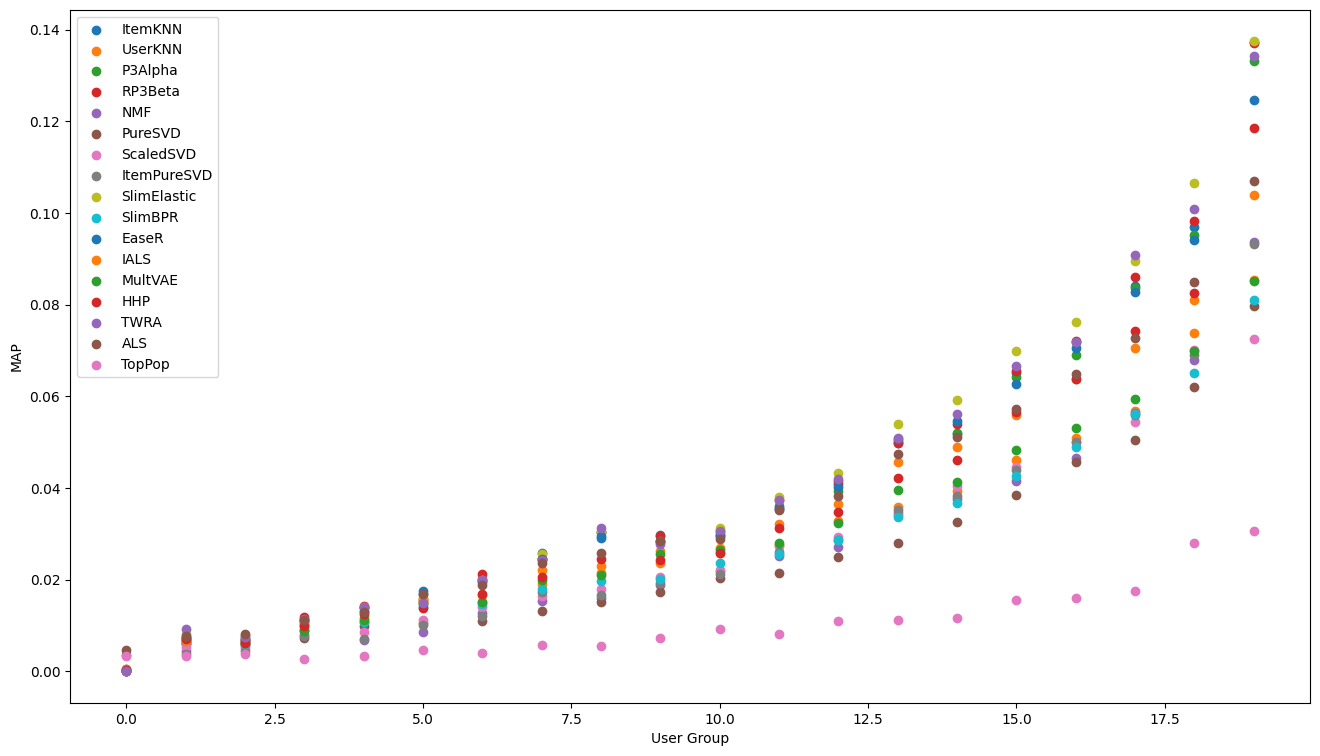

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

In [32]:
group_best = []
group_best_labels = []

for group_id in range(20):
    best = None
    best_map = -1
    for recommender in MAP_recommender_per_group.keys():
        if MAP_recommender_per_group[recommender][group_id] > best_map:
            best_map = MAP_recommender_per_group[recommender][group_id]
            best = recommender
    group_best_labels.append(best)
    group_best.append(recommender_object_dict[best])
group_best_labels

['ALS',
 'TWRA',
 'ALS',
 'RP3Beta',
 'RP3Beta',
 'ItemKNN',
 'RP3Beta',
 'ItemKNN',
 'TWRA',
 'ItemKNN',
 'SlimElastic',
 'SlimElastic',
 'SlimElastic',
 'SlimElastic',
 'SlimElastic',
 'SlimElastic',
 'SlimElastic',
 'TWRA',
 'SlimElastic',
 'SlimElastic']

In [33]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    'ALS': recommender_als,
    'TopPop': recommender_top_pop,
}

group_id_by_user = {}
for group_id in range(20):
    start_pos = group_id * block_size
    end_pos = len(profile_length) if group_id == 19 else (group_id+1) * block_size
    
    users_in_group = sorted_users[start_pos:end_pos]
    for user in users_in_group:
        group_id_by_user[user] = group_id
recommenders_per_group = [recommender_object_dict[label] for label in group_best_labels]

In [34]:
for user_id in range(URM_train.shape[0]):
    if user_id not in group_id_by_user:
        print('Missing user {}'.format(user_id))

In [35]:
class UserGroupDiscriminantHybridRecommender(BaseRecommender):
    def __init__(self, URM_train, group_id_by_user, recommenders_per_group):
        super(UserGroupDiscriminantHybridRecommender, self).__init__(URM_train)
        self.group_id_by_user = group_id_by_user
        self.recommenders_per_group = recommenders_per_group
        
    def recommend(self, user_ids, cutoff=10, remove_seen_flag=True, remove_top_pop_flag=False, return_scores=True, remove_custom_items_flag=True):
        recommendations = np.empty((0, cutoff), dtype=int)
        scores = np.empty((0, self.n_items), dtype=np.float32)
        for user_id in user_ids:
            user_recommendations, user_scores = self.recommenders_per_group[self.group_id_by_user[user_id]].recommend(
                [user_id],
                cutoff=cutoff,
                remove_seen_flag=remove_seen_flag,
                remove_top_pop_flag=remove_top_pop_flag,
                return_scores=True,
                remove_custom_items_flag=remove_custom_items_flag
            )
            recommendations = np.concatenate([recommendations, user_recommendations], axis=0)
            scores = np.concatenate([scores, user_scores], axis=0)
        
        if return_scores:
            return recommendations, scores
        return recommendations

In [36]:
recommender = UserGroupDiscriminantHybridRecommender(URM_train, group_id_by_user, recommenders_per_group)
result_df, _ = evaluator.evaluateRecommender(recommender)
result_df

Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Processed 1000 ( 9.6%) in 14.46 min. Users per second: 1
EvaluatorHoldout: Processed 2000 (19.1%) in 31.01 min. Users per second: 1
EvaluatorHoldout: Processed 3000 (28.7%) in 45.40 min. Users per second: 1
EvaluatorHoldout: Processed 4000 (38.3%) in 1.02 hour. Users per second: 1
EvaluatorHoldout: Processed 5000 (47.8%) in 1.25 hour. Users per second: 1
EvaluatorHoldout: Processed 6000 (57.4%) in 1.51 hour. Users per second: 1
EvaluatorHoldout: Processed 7000 (66.9%) in 1.74 hour. Users per second: 1
EvaluatorHoldout: Processed 8000 (76.5%) in 1.98 hour. Users per second: 1
EvaluatorHoldout: Processed 9000 (86.1%) in 2.24 hour. Users per second: 1
EvaluatorHoldout: Processed 10000 (95.6%) in 2.48 hour. Users per second: 1
EvaluatorHoldout: Processed 10456 (100.0%) in 2.58 hour. Users per second: 1


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.098489,0.169396,0.14285,0.051768,0.088701,0.286418,0.157574,0.116592,0.530318,0.380092,...,0.802826,0.425752,0.802826,0.072023,10.535658,0.998346,0.207816,0.811626,1.682352,0.299388


In [37]:
recommender_top_pop = TopPop(URM_all)
recommender_top_pop.fit()

recommender_item = ItemKNNCFRecommender(URM_all)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_all)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_all)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_all)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_all)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_pure_svd_item = PureSVDItemRecommender(URM_all)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_all)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_all.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_all)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_all.zip')

recommender_slim = SLIMElasticNetRecommender(URM_all)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_all.zip')

recommender_ease_r = EASE_R_Recommender(URM_all)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_all.zip')

recommender_ials = IALSRecommender(URM_all)
recommender_ials.load_model('/kaggle/working/', 'ials_all.zip')

recommender_vae = MultVAERecommender(URM_all)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_all')

recommender_hhp = HHPRecommender(URM_all)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_all)
recommender_twra.fit(**params_twra)

recommender_als = ALSImplicitRecommender(URM_all)
recommender_als.load_model('/kaggle/working/', 'als_all.npz')

TopPopRecommender: URM Detected 386 ( 3.0%) users with no interactions.
TopPopRecommender: URM Detected 125 ( 0.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Similarity column 22347 (100.0%), 4253.74 column/sec. Elapsed time 5.25 sec
UserKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Similarity column 13024 (100.0%), 3945.82 column/sec. Elapsed time 3.30 sec
RP3betaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
RP3betaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2598.09 column/sec. Elapsed time 8.60 sec
P3alphaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
P3alphaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
P3alphaRecommend

In [38]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    'ALS': recommender_als,
    'TopPop': recommender_top_pop,
}

recommenders_per_group = [recommender_object_dict[label] for label in group_best_labels]

In [39]:
user_discriminative_recommender = UserGroupDiscriminantHybridRecommender(URM_all, group_id_by_user, recommenders_per_group)

recommendations = user_discriminative_recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10, return_scores=False)
recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
display(submission_df.head())

submission_df.to_csv('/kaggle/working/submission_user_discriminative.csv', index=False)

Recommender_Base_Class: URM Detected 386 ( 3.0%) users with no interactions.
Recommender_Base_Class: URM Detected 125 ( 0.6%) items with no interactions.


,user_id,item_list
0,1,101 36 123 506 515 403 694 1546 52 1422
1,2,1095 12 47 1522 50 656 949 359 54 102
2,3,59 239 259 857 4252 9 511 584 536 956
3,4,249 28 50 314 171 146 139 254 187 128
4,5,1570 77 131 116 5138 766 148 1220 1511 8664
